# AR simulation

### 1. Imports and constants

In [1]:
import copy

import numpy as np
%load_ext autoreload
%autoreload 2

# Add project to path
import os
import sys

import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from lib.generate.generate_ar import generate_stationary_ar_coefficients, simulate_ar
from lib.dataprocessor.ArDataProcessor import ArDataProcessor
from lib.models.ArModale import ArModel
from lib.loss.Mse import Mse

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def run_one_simulation_on_test_size(degree, seed, models):
    # generate data
    ar_coefficients = generate_stationary_ar_coefficients(degree=degree, seed=seed)
    series = simulate_ar(ar_coefficients, sigma, length, seed=seed)
    
    # process data
    x, y = data_processor.process(series)
    
    # split data
    train_size = int(length * train_ratio)
    test_size = int(length * test_ratio)
    theoretical_risk_estimator_size = int(length * theoretical_risk_estimator_ratio)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_test = x[train_size:train_size + test_size]
    y_test = y[train_size:train_size + test_size]
    x_theoretical_risk_estimator = x[-theoretical_risk_estimator_size:]
    y_theoretical_risk_estimator = y[-theoretical_risk_estimator_size:]
    
    
    
    test_predictions = {}
    theoretical_risk_predictions = {}
    
    test_predictions['y'] = np.ravel(y_test)
    theoretical_risk_predictions['y'] = np.ravel(y_theoretical_risk_estimator)
    
    # fit and predict for each model
    for model in models:
        model = model.fit(x_train, y_train)
        test_predictions[model.name] = np.ravel(model.predict(x_test))
        theoretical_risk_predictions[model.name] = np.ravel(model.predict(x_theoretical_risk_estimator))
    
    # oracle predictions
    oracle = ArModel(degree)
    oracle = oracle.force_coef(ar_coefficients)
    
    test_predictions['oracle'] = np.ravel(oracle.predict(x_test))
    theoretical_risk_predictions['oracle'] = np.ravel(oracle.predict(x_theoretical_risk_estimator))
    
    test_values_and_predictions = pd.DataFrame(test_predictions)
    theoretical_risk_estimator_values_and_predictions = pd.DataFrame(theoretical_risk_predictions)
    
    
    # loss
    test_loss = loss.compute_from_dataframe(test_values_and_predictions, [model.name for model in models])
    theoretical_risk = loss.compute_from_dataframe(theoretical_risk_estimator_values_and_predictions, [model.name for model in models]).mean(axis=0)
    
    # select best model
    non_oracle_models_loss = test_loss[[model.name for model in models]]
    best_model_theoretical_risk = []
    for m in range(1, test_size):
        sub_test_loss = non_oracle_models_loss[:m]
        best_model = sub_test_loss.mean(axis=0).idxmin()
        best_model_theoretical_risk.append(copy.deepcopy(theoretical_risk.loc[best_model]))

    return (best_model_theoretical_risk - theoretical_risk.loc['oracle'])/np.array(best_model_theoretical_risk).mean()

In [3]:
def plot_best_ar_model_theoretical_risk(degree, models, nb_simulations, max_test_size):
    ar_theoretical_risk_diffs = []
    for seed in tqdm.tqdm(range(1, nb_simulations)):
        ar_theoretical_risk_diffs.append(run_one_simulation_on_test_size(degree, seed, models))
    mean_best_model_theoretical_risk_ar = np.array(ar_theoretical_risk_diffs).mean(axis=0)
    max_test_size = min(max_test_size, len(mean_best_model_theoretical_risk_ar))
    # plot best_model_theoretical_risk
    #plt.figure(figsize=(20, 10))
    plt.plot(mean_best_model_theoretical_risk_ar[:max_test_size],".")
    plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
    plt.xlabel('Test Size')
    plt.ylabel('Error Difference')
    plt.legend()
    plt.grid(True)
    #plt.show()
    return mean_best_model_theoretical_risk_ar

def plot_from_mean_theoretical_risk(mean_theoretical_risk, max_test_size, max_degree, degree):
    max_test_size = min(max_test_size, len(mean_theoretical_risk))
    plt.figure(figsize=(20, 10))
    plt.plot(mean_theoretical_risk[:max_test_size],".")
    plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
    plt.xlabel('Test Size')
    plt.ylabel('Error Difference')
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
# set constants
length = 100_000
train_ratio = 0.06
test_ratio = 0.04
theoretical_risk_estimator_ratio = 0.9
max_degree = 60
degree = 20
nb_simulations = 10 # fixer les coeff pour toutes les simulations
sigma = 0.1
max_test_size = int(train_ratio * length / 5)

100%|██████████| 9/9 [00:15<00:00,  1.69s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 15.2150399684906


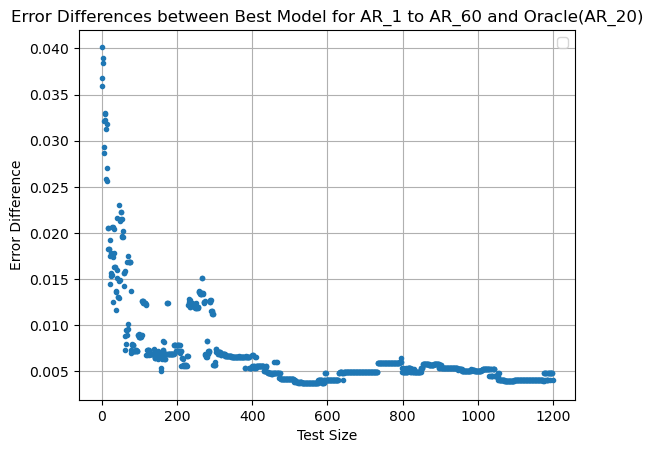

In [5]:
import time

START_TIME = time.time()
data_processor = ArDataProcessor('ar', max_degree)
ar_models = [ArModel(i) for i in range(1, max_degree)]
loss = Mse()
mean_theoretical_risk_ar = plot_best_ar_model_theoretical_risk(degree, ar_models, nb_simulations, max_test_size)
print(f'Elapsed time: {time.time() - START_TIME}')

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


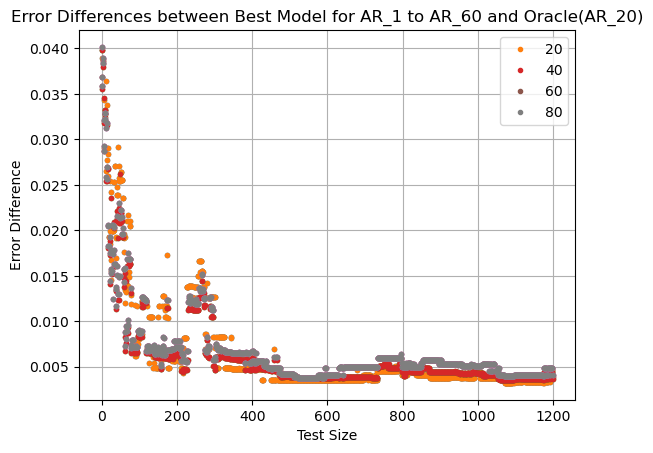

In [6]:
for i in range(20, 100, 20):
    mean_theoretical_risk_ar_i = plot_best_ar_model_theoretical_risk(degree, ar_models[:i], nb_simulations, max_test_size)
    plt.plot(mean_theoretical_risk_ar_i[:max_test_size],".", label=f"{i}")
plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
plt.xlabel('Test Size')
plt.ylabel('Error Difference')
plt.legend()
plt.grid(True)
plt.show()